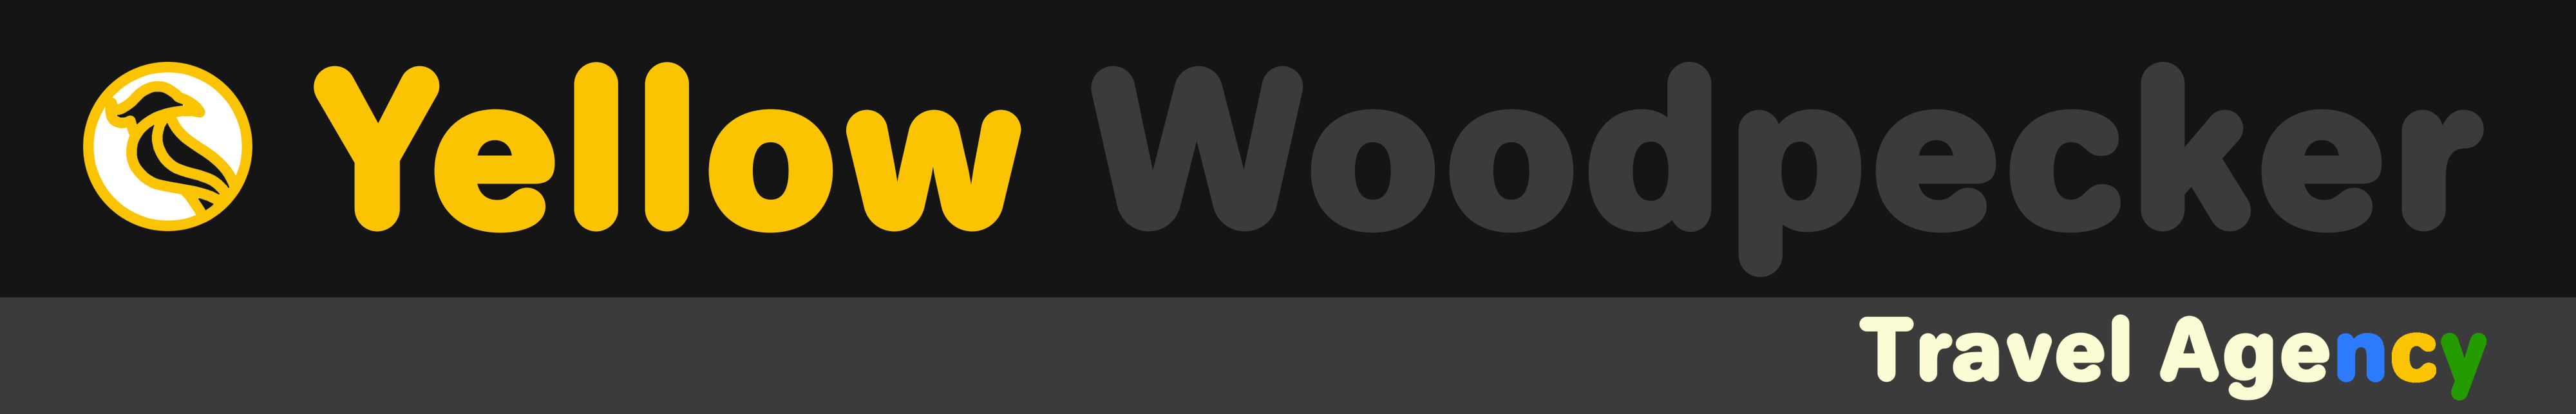

# RECOMMENDING HOTELS BASED ON SIMILAR NEARBY VENUES - CLUSTERING APPROACH

# Introduction

The Yellow Woodpecker (fictional company) is a Brazilian travel agency recognized for the quality of its services. In an effort to improve its services and increase customer retention, the company decided to seek together with its Data Science Team, a possible strategy to improve the satisfaction of its customers. During the analysis, it was noticed that the satisfaction rate to travel accommodation of some customers was significantly getting variation, and not always achieve the expected satisfaction. In view of this, the Data Science Team proposed a project to segment all hotels in the destination trip, and then based on the greater satisfaction of accommodation from a previous trip, create a system to suggest Hotels based on the similarity of nearby venues, to increase the likelihood of high satisfaction with the accommodation service provided.

# Data

The data used was obtained from the Foursquare API, which was performed in 3 steps. 
First, we will search the entire area for a desired city looking for all the hotels in it, and then saving the following information:
-	City
-	City latitude
-	City longitude
-	Hotel name
-	Hotel Id
-	Hotel latitude
-	Hotel longitude

Then, for each hotel found, was make a new request to the API to obtain the evaluation score of each venue (hotel).
-	Ratings

Finally, for each hotel, was make a new request to obtain all nearby venues in a 500 meters radius, then save the following information:
-	Venue Name
-	Venue Latitude
-	Venue Longitude
-	Venue Category

# Importing Required Packages

First we need to import required modules in this project:

<li>Numpy - Library of tools for numerical computation.
<li>Pandas - Used to Visualize, Manipulate and Analyse structured data.
<li>Json - Used to Manipulate JSON (JavaScript Object Notation) files.
<li>Requests - Used to HTTP requests.
<li>Matplotlib - It is used for data visualization, through graphs and maps.
<li>SkLearn - The library for implementing and evaluating Machine Learning models.
<li>Folium - It is used to generate visualization of interactive maps.
<li>Geopy - Used to get geographic coordinates.
<li>IPython.display - Module used for screen viewing.

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize

import json
import requests

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

#!pip install geopy
#!pip install folium==0.5.0
import folium
from geopy.geocoders import Nominatim

from IPython.display import Image

print("All packages have been imported")

All packages have been imported


In [2]:
# Setting matplotlib style
plt.style.use("fivethirtyeight")

# Define Foursquare Credentials and Version

Foursquare: Is an independent location data platform for understanding how people move through the real world.

We will use this platform to acquire, via API request, information about venues in a radius n km from a given location.

In [ ]:
CLIENT_ID = 'YOUR-ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR-SECRET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

# Getting Lat-long Coordinates from Paris 

Getting Paris geographic coordinates, using geopy library

In [4]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


# Getting Hotels Information from Paris

### Define the url to get hotel by Fousquare hotel code

Although we set the search radius to 10_000 meters, it is need to know that by default, the query return only 100 locations, due to the limitation of the Foursquare API.

In [ ]:
radius = 10000 #set the radius search 
hotel_foursquare_code = '4bf58dd8d48988d1fa931735'
url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    hotel_foursquare_code,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

### Retrieve and Store the received Data into a Dataframe

In [6]:
results = requests.get(url).json()["response"]['groups'][0]['items']
results
name = address
venues_list=[]

venues_list.append([(
    name, 
    latitude, 
    longitude, 
    v['venue']['name'], 
    v['venue']['id'], 
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
    v['venue']['categories'][0]['name']) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

nearby_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,"Paris, France",48.856697,2.351462,Hôtel Le Meurice,4b8b0cbef964a5203b9032e3,48.865333,2.328137,Hotel
1,"Paris, France",48.856697,2.351462,Hôtel Bel Ami,4b6ae8dbf964a52066e62be3,48.854918,2.333141,Hotel
2,"Paris, France",48.856697,2.351462,InterContinental Paris Le Grand Hôtel,4adcda03f964a520d13121e3,48.870836,2.330725,Hotel
3,"Paris, France",48.856697,2.351462,Hôtel Mandarin Oriental,4d61286a1ee8721e010db321,48.866987,2.327178,Hotel
4,"Paris, France",48.856697,2.351462,Grand Hôtel du Palais Royal,4b50f4d4f964a5207e3a27e3,48.863183,2.337901,Hotel


### Filtering dataframe by 'Venue Category' that contains 'Hotel'

To ensure that on our dataframe there are only Places categorized as 'Hotel', a filter is made by category.

In [7]:
nearby_venues = nearby_venues[nearby_venues['Venue Category'].str.contains('Hotel')]
nearby_venues.reset_index(inplace=True, drop=True)
print(nearby_venues.shape)
nearby_venues.head()

(100, 8)


,City,City Latitude,City Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,"Paris, France",48.856697,2.351462,Hôtel Le Meurice,4b8b0cbef964a5203b9032e3,48.865333,2.328137,Hotel
1,"Paris, France",48.856697,2.351462,Hôtel Bel Ami,4b6ae8dbf964a52066e62be3,48.854918,2.333141,Hotel
2,"Paris, France",48.856697,2.351462,InterContinental Paris Le Grand Hôtel,4adcda03f964a520d13121e3,48.870836,2.330725,Hotel
3,"Paris, France",48.856697,2.351462,Hôtel Mandarin Oriental,4d61286a1ee8721e010db321,48.866987,2.327178,Hotel
4,"Paris, France",48.856697,2.351462,Grand Hôtel du Palais Royal,4b50f4d4f964a5207e3a27e3,48.863183,2.337901,Hotel


### Saving the dataframe progress

In [8]:
nearby_venues.to_csv('paris/current_nearby_venues.csv', index=False)

### Reading Data

As we use real and current data collected from Foursquare, such data can change quickly, for example, a hotel ceases to exist, or even change its location. For this reason, we will upload the data that was collected on 16/01/2021, so we can make shure that the analysis performed on this notebook actually makes sense for the data used.

If you want to use data collected at the current moment of execution of this notebook, just comment the line below, known however that the analysis and reported results may not reflect this data, an example of such a divergence that could occur would be in the optimal number of clusters for the data used.

In [9]:
nearby_venues = pd.read_csv('paris/paris_nearby_venues.csv')

# Getting ratings from Venue (Hotel) Id

This part of the code will only be for demonstration of operation, since the requisition of ratings per venue is considered a premium requisition and is limited to 50 requisitions per day. So in this first moment we will collect only 10, in order to show how it works. The dataset with the ratings that will actually be used was collected througt 3 days.

### Creating Subset with 10th first rows

In [10]:
nearby_venues_10 = nearby_venues.head(10)
nearby_venues_10.to_csv('paris/paris_nearby_venues_10.csv', index=False)
nearby_venues_10.head()

,City,City Latitude,City Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,"Paris, France",48.856697,2.351462,Hôtel Le Meurice,4b8b0cbef964a5203b9032e3,48.865333,2.328137,Hotel
1,"Paris, France",48.856697,2.351462,Hôtel Bel Ami,4b6ae8dbf964a52066e62be3,48.854918,2.333141,Hotel
2,"Paris, France",48.856697,2.351462,InterContinental Paris Le Grand Hôtel,4adcda03f964a520d13121e3,48.870836,2.330725,Hotel
3,"Paris, France",48.856697,2.351462,Grand Hôtel du Palais Royal,4b50f4d4f964a5207e3a27e3,48.863183,2.337901,Hotel
4,"Paris, France",48.856697,2.351462,Hôtel Les Jardins du Marais,4b7051cdf964a5205b122de3,48.860699,2.368530,Hotel


### Retrieve Rating

Defining a function that request the ratings score for each Hotel contained in the dataframe

In [11]:
def get_rating(df):
    
    ratings = []
    for venue_id in df['Venue Id']:
        hotel_foursquare_id = venue_id

        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            hotel_foursquare_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        
        results = requests.get(url).json()["response"]["venue"]["rating"]
        ratings.append(results)
    
    df.insert(5, 'Ratings', ratings)

### Getting Ratings

In [12]:
get_rating(nearby_venues_10)
nearby_venues_10.head()

,City,City Latitude,City Longitude,Venue,Venue Id,Ratings,Venue Latitude,Venue Longitude,Venue Category
0,"Paris, France",48.856697,2.351462,Hôtel Le Meurice,4b8b0cbef964a5203b9032e3,8.8,48.865333,2.328137,Hotel
1,"Paris, France",48.856697,2.351462,Hôtel Bel Ami,4b6ae8dbf964a52066e62be3,8.7,48.854918,2.333141,Hotel
2,"Paris, France",48.856697,2.351462,InterContinental Paris Le Grand Hôtel,4adcda03f964a520d13121e3,8.6,48.870836,2.330725,Hotel
3,"Paris, France",48.856697,2.351462,Grand Hôtel du Palais Royal,4b50f4d4f964a5207e3a27e3,8.3,48.863183,2.337901,Hotel
4,"Paris, France",48.856697,2.351462,Hôtel Les Jardins du Marais,4b7051cdf964a5205b122de3,7.8,48.860699,2.368530,Hotel


### Saving DataFrame

In [13]:
nearby_venues_10.to_csv('paris/paris_nearby_venues_10_ratings.csv', index=False)

### Testing Foursquare Conection and Premium Request Limit

If the above function returns an error, possibly the Foursquare request limit has been reached. To confirm this occurrence, uncomment the second code cell below and continue with the execution.

To perform the test below, a premium request is made for a single store id. If it is within the request limit, a json will be returned containing the establishment's information, otherwise the returned json will contain an error message, with the following message: 'errorType': 'quota_exceeded'.

In [14]:
def test_conection():
    hotel_foursquare_id = '4b0563c0f964a5200e5822e3'
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        hotel_foursquare_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    url

    results = requests.get(url).json()
    print(results)

In [15]:
#test_conection()

# Filtering Hotel Columns from DataFrame

Back to the original dataframe, a filter is performed on the columns in order to remove the columns related to the city information of the hotels location. Such a column is not necessary, as all hotels are in the same city (Paris).

In [16]:
hotel_venues = nearby_venues[['Venue', 'Venue Latitude', 'Venue Longitude']]
hotel_venues.columns = ['Hotel', 'Hotel Latitude', 'Hotel Longitude']
hotel_venues.head()

,Hotel,Hotel Latitude,Hotel Longitude
0,Hôtel Le Meurice,48.865333,2.328137
1,Hôtel Bel Ami,48.854918,2.333141
2,InterContinental Paris Le Grand Hôtel,48.870836,2.330725
3,Grand Hôtel du Palais Royal,48.863183,2.337901
4,Hôtel Les Jardins du Marais,48.860699,2.368530


# Visualize all Hotels in a map

Here we use the folium package to create an interactive map that makes it possible to view all hotels on our dataframe centralized in the city of Paris (France).

In [17]:
# create map of hotels using latitude and longitude values
map_hotels = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, venue in zip(hotel_venues['Hotel Latitude'], hotel_venues['Hotel Longitude'], 
                                           hotel_venues['Hotel']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_hotels)  
    
map_hotels

As the map created above is interactive, it may not be visible on github. So we will import and show below the result of the preview obtained on 16/01/21.

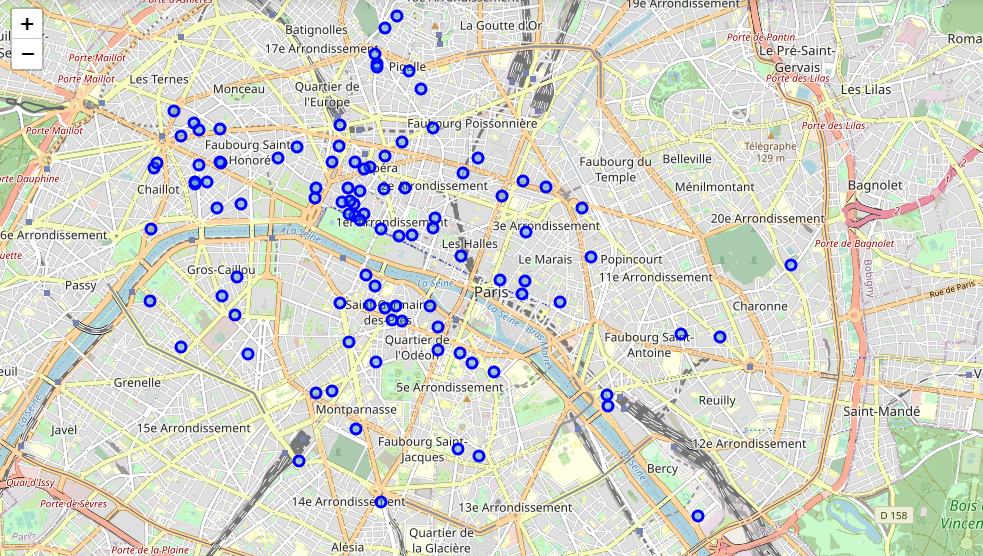

In [18]:
Image(filename='folium_maps/folium_hotels_map.png') 

# Get the top 100 venues that are in each Hotel within a radius of 300 meters.

To segment the hotels, we will use the nearby venues for each hotel within a radius of 500 meters, and then we will create a new DataFrame grouping that informations.

### Get Nearby Venues Function

Function that receives data from nearby venues from certain local (Hotel), using a request to the Foursquare API.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hotel', 
                  'Hotel Latitude', 
                  'Hotel Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting Nearby Venues

In [20]:
get_venues = getNearbyVenues(names=nearby_venues['Venue'],
                                   latitudes=nearby_venues['Venue Latitude'],
                                   longitudes=nearby_venues['Venue Longitude'])

Hôtel Le Meurice
Hôtel Bel Ami
InterContinental Paris Le Grand Hôtel
Grand Hôtel du Palais Royal
Hôtel Les Jardins du Marais
Le Bristol
W Paris – Opéra
Hôtel Plaza Athénée
Hôtel Four Seasons George V
Hôtel Prince de Galles
Hôtel Costes
Hôtel Barrière Le Fouquet's
Mama Shelter
Artus Hotel
Grand Hôtel Français
Shangri-La Hotel Paris
Hôtel Le Royal Monceau Raffles
Hôtel Arès Tour Eiffel
The Peninsula Paris
Hôtel Pullman Paris Centre - Bercy
Hôtel Caron de Beaumarchais
Hôtel Renaissance Paris Vendôme
Hotel Atmospheres
Hôtel Jules & Jim
Renaissance Paris Arc de Triomphe Hotel
Hôtel Pullman Paris Tour Eiffel
Hôtel Providence
The Hoxton Paris
Hôtel Paris Marriott Champs-Élysées
Novotel Paris Les Halles
Renaissance Paris Republique Hotel
Le 123 Sébastopol
New Hotel Roblin
Hôtel Ritz
Hôtel Jeanne d'Arc
Hôtel Verneuil
Hôtel Lutetia
Le General Hotel
Fraser Suites Le Claridge Champs-Élysées
Hôtel Mandarin Oriental
Hôtel de Crillon
Hilton
Hôtel Dupond-Smith
Hôtel Brighton
Hôtel Madison
Petit Belloy

### Showing DataFrame Head's

In [21]:
get_venues.head()

,Hotel,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hôtel Le Meurice,48.865333,2.328137,Librairie Galignani,48.864989,2.328570,Bookstore
1,Hôtel Le Meurice,48.865333,2.328137,Hôtel Mandarin Oriental,48.866987,2.327178,Hotel
2,Hôtel Le Meurice,48.865333,2.328137,Le Dalí,48.865333,2.328137,French Restaurant
3,Hôtel Le Meurice,48.865333,2.328137,Balagan,48.865432,2.329680,Israeli Restaurant
4,Hôtel Le Meurice,48.865333,2.328137,Hôtel Le Meurice,48.865333,2.328137,Hotel


### Saving DataFrame

In [22]:
get_venues.to_csv('paris/current_get_venues.csv', index=False)

### Loading DataFrame

As previously mentioned, we will use the data collected on 1/16/2021 to continue with this project.

If you want to use the data collected on the current day of execution of this notebook, just comment the line below.

In [23]:
get_venues = pd.read_csv('paris/paris_get_venues.csv')

# Grouping DataFrame

Counting how many locations were returned for each Hotel

In [24]:
get_venues.groupby('Hotel').count()

,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Hotel,,,,,,
7 Eiffel Hotel****,71,71,71,71,71,71
Artus Hotel,50,50,50,50,50,50
Champs Elysées Friedland,42,42,42,42,42,42
Citadines Saint-Germain-des-Prés Paris,51,51,51,51,51,51
Cordelia Hotel,66,66,66,66,66,66
Courtyard by Marriott Paris Gare de Lyon,51,51,51,51,51,51
Fraser Suites Le Claridge Champs-Élysées,31,31,31,31,31,31
Grand Hôtel Français,27,27,27,27,27,27
Grand Hôtel du Palais Royal,22,22,22,22,22,22


# Unique Categories

Returning how many unique categories were found among all returned Places.

In [25]:
print('There are {} uniques categories.'.format(len(get_venues['Venue Category'].unique())))

There are 253 uniques categories.


# Analyze Each Hotel Center

### One Hot Encode

Not all machine learning algorithms can work directly with categorical variables, as they need to perform numerical calculations on them. Therefore, it is necessary to look for a way to represent the obtained data numerically. 

In this Project ‘One Hot Encoding’ was used, which is a form of numerical representation for categorical data that does not have an ordinal relationship, where a value of 1 is assigned when there is an observation for a given group and 0 for when there is no occurrence.

In [26]:
# one hot encoding
get_venues_onehot = pd.get_dummies(get_venues[['Venue Category']], prefix="", prefix_sep="")

# add Hotel column back to dataframe
get_venues_onehot['Hotel'] = get_venues['Hotel'] 

# heading dataframe
get_venues_onehot.head()

,Accessories Store,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Caucasian Restaurant,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Internet Cafe,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laser Tag,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Ordering dataframe columns

To improve visualization, we will order the DataFrame so that the 'Hotel' column becomes the first.

In [27]:
# get columns name as list
cols = get_venues_onehot.columns.tolist()

# get index Hotel column
index = cols.index('Hotel')

# pop (remove) 'Hotel' from list
cols.pop(index)

# create list starting with [Hotel] + [list]
cols = ['Hotel'] + cols

# set new column order
get_venues_onehot = get_venues_onehot[cols]

# heading dataframe
get_venues_onehot.head()

,Hotel,Accessories Store,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Caucasian Restaurant,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Internet Cafe,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laser Tag,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Hôtel Le Meurice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Showing DataFrame Size (n_rows, n_columns)

In [28]:
get_venues_onehot.shape

(5016, 253)

### Saving Dataframe

In [29]:
get_venues_onehot.to_csv('paris/paris_get_venues_onehot.csv', index=False)

### Grouping rows by Hotel, taking the mean frequency of occurrence for each category

In [30]:
get_venues_grouped = get_venues_onehot.groupby('Hotel').mean().reset_index()
get_venues_grouped.head()

,Hotel,Accessories Store,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Caucasian Restaurant,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Internet Cafe,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laser Tag,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,7 Eiffel Hotel****,0.0,0.0,0.0,0.014085,0.0,0.0,0.000000,0.014085,0.0,0.0,0.014085,0.0,0.0,0.0,0.0,0.0,0.028169,0.028169,0.0,0.014085,0.00000,0.00,0.0,0.0,0.0,0.0,0.0,0.014085,0.0,0.000000,0.000000,

In [31]:
# New dataframe size
get_venues_grouped.shape

(100, 253)

### Saving Dataframe

In [32]:
get_venues_grouped.to_csv('paris/paris_get_venues_grouped.csv', index=False)

# Get Top Most Commom Venues

### Let's print each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5

for hood in get_venues_grouped['Hotel']:
    print("----"+hood+"----")
    temp = get_venues_grouped[get_venues_grouped['Hotel'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----7 Eiffel Hotel****----
                venue  freq
0   French Restaurant  0.18
1  Italian Restaurant  0.07
2        Cocktail Bar  0.04
3           Irish Pub  0.03
4              Bakery  0.03


----Artus Hotel----
                venue  freq
0               Plaza  0.08
1            Wine Bar  0.06
2  Seafood Restaurant  0.06
3      Chocolate Shop  0.06
4   French Restaurant  0.06


----Champs Elysées Friedland----
               venue  freq
0  French Restaurant  0.14
1        Salad Place  0.07
2               Café  0.05
3   Asian Restaurant  0.05
4             Bakery  0.02


----Citadines Saint-Germain-des-Prés Paris----
                 venue  freq
0    French Restaurant  0.24
1                Plaza  0.06
2  Japanese Restaurant  0.04
3                  Bar  0.04
4               Museum  0.04


----Cordelia Hotel----
               venue  freq
0  French Restaurant  0.11
1        Salad Place  0.06
2           Boutique  0.05
3   Department Store  0.05
4       Gourmet Shop  0.05


----Co

4       Gourmet Shop  0.04


----Hôtel Seven----
                venue  freq
0  Italian Restaurant  0.14
1                Café  0.09
2   French Restaurant  0.09
3          Restaurant  0.05
4    Sushi Restaurant  0.05


----Hôtel Sofitel Paris Le Faubourg----
               venue  freq
0           Boutique  0.18
1  French Restaurant  0.12
2      Women's Store  0.09
3        Men's Store  0.05
4         Shoe Store  0.04


----Hôtel Square Louvois----
                 venue  freq
0  Japanese Restaurant  0.14
1    French Restaurant  0.08
2   Italian Restaurant  0.06
3             Wine Bar  0.06
4               Bakery  0.04


----Hôtel Verneuil----
                venue  freq
0   French Restaurant  0.25
1                Café  0.09
2  Italian Restaurant  0.07
3              Bakery  0.02
4           Gastropub  0.02


----Hôtel Villa Saxe Eiffel----
                 venue  freq
0               Bistro  0.14
1    French Restaurant  0.14
2                Plaza  0.07
3  Rental Car Location  0.07
4 

### Put that into a pandas dataframe

Define a function to sort the venues in descending order.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Puting into a dataframe

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues [1st, 2nd, 3rd, 4th, ..., nth]
columns = ['Hotel']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hotel_venues_sorted = pd.DataFrame(columns=columns)
hotel_venues_sorted['Hotel'] = get_venues_grouped['Hotel']

for ind in np.arange(get_venues_grouped.shape[0]):
    hotel_venues_sorted.iloc[ind, 1:] = return_most_common_venues(get_venues_grouped.iloc[ind, :], num_top_venues)

hotel_venues_sorted.head()

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,7 Eiffel Hotel****,French Restaurant,Italian Restaurant,Cocktail Bar,Coffee Shop,Bar,Bakery,Café,Irish Pub,Cheese Shop,Dessert Shop
1,Artus Hotel,Plaza,Chocolate Shop,Seafood Restaurant,Wine Bar,French Restaurant,Bookstore,Clothing Store,Cocktail Bar,Italian Restaurant,Pastry Shop
2,Champs Elysées Friedland,French Restaurant,Salad Place,Café,Asian Restaurant,Pub,Gym / Fitness Center,Bed & Breakfast,Middle Eastern Restaurant,Brasserie,Cocktail Bar
3,Citadines Saint-Germain-des-Prés Paris,French Restaurant,Plaza,Japanese Restaurant,Asian Restaurant,Museum,Restaurant,Bar,Café,Bookstore,Bistro
4,Cordelia Hotel,French Restaurant,Salad Place,Department Store,Boutique,Gourmet Shop,Theater,Coffee Shop,Clothing Store,Restaurant,Lounge


### Saving DataFrame

In [36]:
hotel_venues_sorted.to_csv('paris/paris_hotel_venues_sorted.csv', index=False)

# Clustering Hotels

Clustering or grouping is the task of split a data set into subsets forming groups where all data points within the same group are more similar to each other than compared to a point in another group.

### Create a new dataframe without 'Hotel' column

In [37]:
get_venues_grouped_clustering = get_venues_grouped.drop('Hotel', 1)
get_venues_grouped_clustering.head()

,Accessories Store,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Caucasian Restaurant,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Internet Cafe,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laser Tag,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.014085,0.0,0.0,0.000000,0.014085,0.0,0.0,0.014085,0.0,0.0,0.0,0.0,0.0,0.028169,0.028169,0.0,0.014085,0.00000,0.00,0.0,0.0,0.0,0.0,0.0,0.014085,0.0,0.000000,0.000000,0.014085,0.0,0.0,0.00,0.0

### Saving DataFrame

In [38]:
get_venues_grouped_clustering.to_csv('paris/paris_get_venues_grouped_clustering.csv', index=False)

# K-Means

K-Means is an unsupervised learning algorithm, which groups data trying to separate samples into n groups of equal variance, minimizing the known criterion as inertia or through the error of the sum of the squares of a cluster (group). 

In this algorithm it is necessary to specify previously the k number of clusters (groups) in which the data will be grouped. Therefore, it is needed to find the best k number of clusters that results in the greatest possible similarity between data from the same cluster and at the lowest similarity between the different clusters.

To perform this task, we used several models with k values from 1 to 10, then two metrics were used to evaluate the results, known as, Elbow Method and Silhouette Method.

### Best K - Elbow Method

This method tests the variance of the data in relation to the number of clusters, in order to present the point k at which the increase in the number of clusters does not represent a significant value of cost reduction when compared to the variance between the previous k.

In [39]:
def find_k(data, k = 10):
    
    cost = []
    
    for i in range (1, k+1):
        # run k-means clustering
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans = kmeans.fit(data)
        
        # calculates squared error for the clustered points
        cost.append(kmeans.inertia_)
    
    # plot (K Value) x (Squared Error - Cost)
    plt.plot(range(1, k+1), cost, linewidth='3')
    plt.xlabel("K Value")
    plt.xticks(np.arange(1, k+1, 1))
    plt.ylabel("Squared Error - Cost")
    plt.title("Elbow Method")
    plt.show

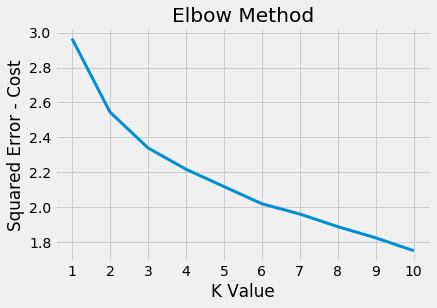

In [40]:
find_k(get_venues_grouped_clustering)

In some cases (such as the one above), the Elbow method may not clearly represent the best k to be chosen, as this method is a visual inspection of the values, which is not always very clear. The above case, for example, does not make it very clear which k is better, it is only observed that this value is between 2 and 6. Therefore, the ideal is to have more than one form of evaluation.

### Best K - Silhouette Method

The Silhouette Method is used to measure the resulting separation distance between two clusters. The Silhouette coefficient close to 0 represents that the sample is at, or very close to, the border between two neighboring clusters. A value close to 1 indicates that the sample is far from neighboring clusters. 

In [41]:
def find_kk(data, k = 10):
    from sklearn.metrics import silhouette_score
    
    sil = []
    
    for i in range (2, k+1):
        # run k-means clustering
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans = kmeans.fit(data)
        
        labels = kmeans.labels_
        
        # calculates squared error for the clustered points
        sil.append(silhouette_score(data, labels, metric='euclidean'))
    
    print(sil)
    # plot (K Value) x (Squared Error - Cost)
    plt.plot(range(2, k+1), sil, linewidth='3')
    plt.xlabel("K Value")
    plt.xticks(np.arange(1, k+1, 1))
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Method")
    plt.show

[0.14513271907766004, 0.08314051321084627, 0.0630378511825377, 0.07216364791338871, 0.09351390719736254, 0.08283062474988265, 0.05239335286795454, 0.08800613973758808, 0.055254863826469124]


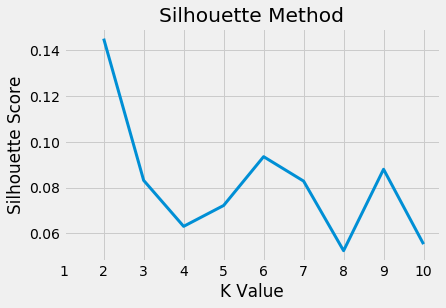

In [42]:
find_kk(get_venues_grouped_clustering)

With the figure above, we observed the highest Silhouette coefficient was achieved for k = 2, thus resulting in 2 clusters, but only 2 clusters for our application would not be very useful, as making a suggestion of hotels based on only 2 groups, limits the variety of choice between different clusters. So, in this project we will use the second-best k (k = 6) according to the Silhouette method, which also coincides with the possible good values observed in the Elbow method. With that we trained our K-Means model with 6 clusters.

### Clustering by the best k

As discussed above, the k will be 6

In [43]:
# set number of clusters for the best k
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(get_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 4, 3, 2, 3, 2, 2, 0, 3, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# Insert Cluster labels and Merge Dataset.

In [44]:
# add clustering labels
hotel_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# set a new dataset
nearby_venues_merged = hotel_venues

# merge get_venues_grouped with hotel_venues to add latitude/longitude for each Hotel
nearby_venues_merged = nearby_venues_merged.join(hotel_venues_sorted.set_index('Hotel'), on='Hotel')

nearby_venues_merged.head()

,Hotel,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hôtel Le Meurice,48.865333,2.328137,1,French Restaurant,Café,Hotel Bar,Chocolate Shop,Japanese Restaurant,Pastry Shop,Beer Garden,Clothing Store,Bookstore,Dessert Shop
1,Hôtel Bel Ami,48.854918,2.333141,5,Italian Restaurant,French Restaurant,Plaza,Café,Japanese Restaurant,Cosmetics Shop,Clothing Store,Boutique,Sandwich Place,Steakhouse
2,InterContinental Paris Le Grand Hôtel,48.870836,2.330725,4,Chocolate Shop,Coffee Shop,Clothing Store,Men's Store,Electronics Store,Sandwich Place,Candy Store,French Restaurant,Furniture / Home Store,Roof Deck
3,Grand Hôtel du Palais Royal,48.863183,2.337901,2,French Restaurant,Plaza,Café,Historic Site,Coffee Shop,Theater,Shoe Store,Spa,Sculpture Garden,Garden
4,Hôtel Les Jardins du Marais,48.860699,2.368530,3,Bar,Café,French Restaurant,Restaurant,Art Gallery,Clothing Store,Pizza Place,Coffee Shop,Tea Room,Bistro


### Saving DataFrame

In [45]:
nearby_venues_merged.to_csv('paris/paris_nearby_venues_merged.csv', index=False)

# Visualize all Hotels by Cluster

Finally, we will visualize on a map the result of the grouping of the Hotels. To create this interactive map, the Folium package was used.

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nearby_venues_merged['Hotel Latitude'], nearby_venues_merged['Hotel Longitude'], 
                                  nearby_venues_merged['Hotel'], nearby_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

As the map created above is interactive, it may not be visible on github. So we will import and show below the result of the preview obtained on 16/01/21.

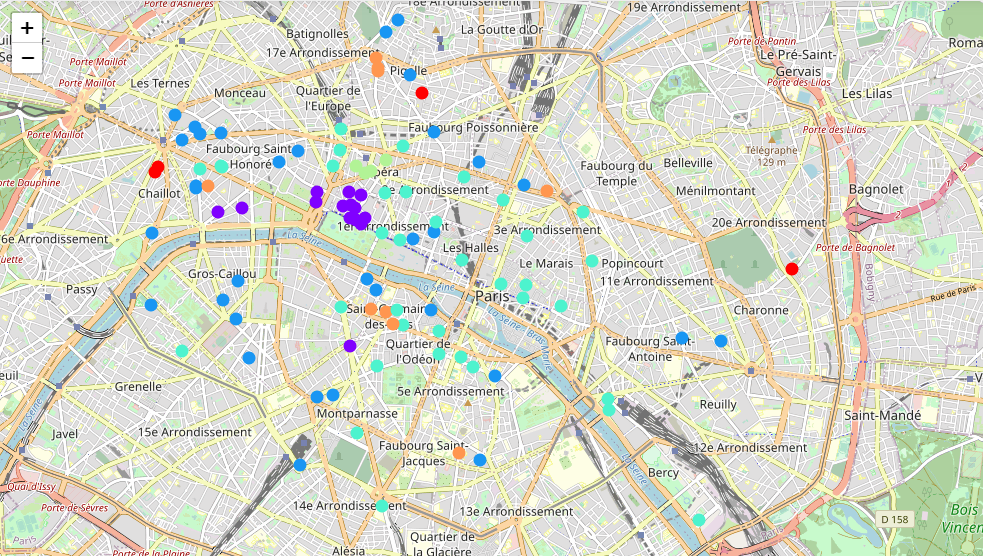

In [47]:
Image(filename='folium_maps/folium_clustering_map.png') 

# Examine Clusters

Now, we can view the information for each cluster and try to understand which categories of locations distinguish one cluster from another.

### Cluster 1

In [48]:
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 0, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Mama Shelter,French Restaurant,Bus Station,Pizza Place,Roof Deck,Lounge,Bistro,Grocery Store,Supermarket,Event Service,Escape Room
18,The Peninsula Paris,French Restaurant,Steakhouse,Vegetarian / Vegan Restaurant,Roof Deck,Bakery,Molecular Gastronomy Restaurant,Farmers Market,Fast Food Restaurant,Falafel Restaurant,Electronics Store
73,Hôtel Amour,French Restaurant,Bakery,Cheese Shop,Café,Cocktail Bar,Coffee Shop,Plaza,Falafel Restaurant,Farmers Market,Exhibit
97,Hôtel Raphaël,French Restaurant,Bakery,Vegetarian / Vegan Restaurant,Roof Deck,Movie Theater,Plaza,Molecular Gastronomy Restaurant,Steakhouse,Exhibit,Falafel Restaurant


### Cluster 2

In [49]:
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 1, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hôtel Le Meurice,French Restaurant,Café,Hotel Bar,Chocolate Shop,Japanese Restaurant,Pastry Shop,Beer Garden,Clothing Store,Bookstore,Dessert Shop
7,Hôtel Plaza Athénée,French Restaurant,Boutique,Italian Restaurant,Seafood Restaurant,Accessories Store,Bistro,Japanese Restaurant,Sandwich Place,Plaza,Brasserie
10,Hôtel Costes,French Restaurant,Jewelry Store,Boutique,Hotel Bar,Chocolate Shop,Accessories Store,Tea Room,Japanese Restaurant,Men's Store,Dessert Shop
21,Hôtel Renaissance Paris Vendôme,French Restaurant,Japanese Restaurant,Jewelry Store,Chocolate Shop,Dessert Shop,Hotel Bar,Plaza,Italian Restaurant,Clothing Store,Café
33,Hôtel Ritz,French Restaurant,Jewelry Store,Chocolate Shop,Boutique,Shoe Store,Cocktail Bar,Hotel Bar,Sandwich Place,Plaza,Men's Store
36,Hôtel Lutetia,French Restaurant,Chocolate Shop,Gourmet Shop,Market,Furniture / Home Store,Coffee Shop,Department Store,Shoe Store,Garden,Art Gallery
39,Hôtel Mandarin Oriental,French Restaurant,Boutique,Jewelry Store,Hotel Bar,Men's Store,Chocolate Shop,Tea Room,Clothing Store,Bookstore,Pastry Shop
40,Hôtel de Crillon,Boutique,Women's Store,French Restaurant,Men's Store,Fountain,Lounge,Tea Room,Accessories Store,Clothing Store,Shoe Store
43,Hôtel Brighton,French Restaurant,Japanese Restaurant,Chocolate Shop,Hotel Bar,Café,Dessert Shop,Jewelry Store,Clothing Store,Garden,Boutique
57,Starhotels Castille Paris,French Restaurant,Boutique,Jewelry Store,Dessert Shop,Gourmet Shop,Men's Store,Accessories Store,Hotel Bar,Women's Store,Cocktail Bar


### Cluster 3

In [50]:
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 2, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Grand Hôtel du Palais Royal,French Restaurant,Plaza,Café,Historic Site,Coffee Shop,Theater,Shoe Store,Spa,Sculpture Garden,Garden
5,Le Bristol,French Restaurant,Bar,Hotel Bar,Theater,Cocktail Bar,Resort,Snack Place,Spa,Mediterranean Restaurant,Bakery
8,Hôtel Four Seasons George V,French Restaurant,Italian Restaurant,Japanese Restaurant,Lebanese Restaurant,Boutique,Sandwich Place,Hotel Bar,Seafood Restaurant,Supermarket,Tapas Restaurant
9,Hôtel Prince de Galles,French Restaurant,Boutique,Japanese Restaurant,Italian Restaurant,Sandwich Place,Tapas Restaurant,Bakery,Lebanese Restaurant,Seafood Restaurant,Hotel Bar
14,Grand Hôtel Français,French Restaurant,Italian Restaurant,Restaurant,Gastropub,Korean Restaurant,Bar,Ethiopian Restaurant,Bistro,Thai Restaurant,Board Shop
15,Shangri-La Hotel Paris,French Restaurant,Art Museum,Hookah Bar,Chinese Restaurant,Market,Bookstore,Arts & Entertainment,Bar,Hotel Bar,Plaza
16,Hôtel Le Royal Monceau Raffles,French Restaurant,Italian Restaurant,Brasserie,Pizza Place,Bistro,Asian Restaurant,Sporting Goods Shop,Spa,Seafood Restaurant,Salad Place
24,Renaissance Paris Arc de Triomphe Hotel,French Restaurant,Italian Restaurant,Pizza Place,Bistro,Bar,Asian Restaurant,Clothing Store,Seafood Restaurant,Japanese Restaurant,Bakery
25,Hôtel Pullman Paris Tour Eiffel,French Restaurant,Café,Creperie,Athletics & Sports,Bus Stop,Sandwich Place,Brasserie,Bistro,Library,Furniture / Home Store
26,Hôtel Providence,French Restaurant,Bar,Theater,Restaurant,Cocktail Bar,Burger Joint,Indie Movie Theater,Coffee Shop,Pizza Place,Chinese Restaurant


### Cluster 4

In [51]:
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 3, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Hôtel Les Jardins du Marais,Bar,Café,French Restaurant,Restaurant,Art Gallery,Clothing Store,Pizza Place,Coffee Shop,Tea Room,Bistro
11,Hôtel Barrière Le Fouquet's,French Restaurant,Asian Restaurant,Café,Pastry Shop,Cosmetics Shop,Clothing Store,Electronics Store,Bakery,Hotel Bar,Halal Restaurant
13,Artus Hotel,Plaza,Chocolate Shop,Seafood Restaurant,Wine Bar,French Restaurant,Bookstore,Clothing Store,Cocktail Bar,Italian Restaurant,Pastry Shop
17,Hôtel Arès Tour Eiffel,French Restaurant,Bakery,Supermarket,Korean Restaurant,Creperie,Pizza Place,Bar,Brasserie,Thai Restaurant,Bike Rental / Bike Share
19,Hôtel Pullman Paris Centre - Bercy,Italian Restaurant,Cosmetics Shop,Breakfast Spot,Supermarket,Big Box Store,Food & Drink Shop,Flea Market,Shopping Plaza,Burger Joint,Miscellaneous Shop
20,Hôtel Caron de Beaumarchais,French Restaurant,Clothing Store,Falafel Restaurant,Pastry Shop,Wine Bar,Plaza,Italian Restaurant,Ice Cream Shop,Bistro,Furniture / Home Store
22,Hotel Atmospheres,French Restaurant,Italian Restaurant,Bakery,Coffee Shop,Tapas Restaurant,Portuguese Restaurant,Seafood Restaurant,Ethiopian Restaurant,Flower Shop,Market
23,Hôtel Jules & Jim,French Restaurant,Chinese Restaurant,Café,Art Gallery,Wine Bar,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Restaurant,Museum
27,The Hoxton Paris,Bar,Cocktail Bar,Wine Bar,French Restaurant,Italian Restaurant,Chinese Restaurant,Theater,Salad Place,Gym / Fitness Center,Indian Restaurant
28,Hôtel Paris Marriott Champs-Élysées,French Restaurant,Cosmetics Shop,Café,Department Store,Clothing Store,Fast Food Restaurant,Seafood Restaurant,Burger Joint,Spa,Multiplex


### Cluster 5

In [52]:
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 4, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,InterContinental Paris Le Grand Hôtel,Chocolate Shop,Coffee Shop,Clothing Store,Men's Store,Electronics Store,Sandwich Place,Candy Store,French Restaurant,Furniture / Home Store,Roof Deck
6,W Paris – Opéra,Coffee Shop,Jewelry Store,French Restaurant,Salad Place,Clothing Store,Chocolate Shop,Sandwich Place,Women's Store,Plaza,Cosmetics Shop
48,Hôtel Scribe,Chocolate Shop,French Restaurant,Sandwich Place,Coffee Shop,Pub,Men's Store,Candy Store,Opera House,Gourmet Shop,Theater
90,Hotel Athenee Paris,Chocolate Shop,Gourmet Shop,French Restaurant,Clothing Store,Furniture / Home Store,Lounge,Wine Shop,Opera House,Sandwich Place,Dessert Shop


### Cluster 6

In [53]:
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 5, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Hôtel Bel Ami,Italian Restaurant,French Restaurant,Plaza,Café,Japanese Restaurant,Cosmetics Shop,Clothing Store,Boutique,Sandwich Place,Steakhouse
30,Renaissance Paris Republique Hotel,Plaza,Art Gallery,Supermarket,Furniture / Home Store,French Restaurant,Cocktail Bar,Seafood Restaurant,Comedy Club,Argentinian Restaurant,Italian Restaurant
44,Hôtel Madison,Italian Restaurant,French Restaurant,Pastry Shop,Clothing Store,Café,Japanese Restaurant,Plaza,Cocktail Bar,Seafood Restaurant,Ice Cream Shop
51,Hôtel Seven,Italian Restaurant,French Restaurant,Café,Restaurant,Sushi Restaurant,Tea Room,Thai Restaurant,Sandwich Place,Cheese Shop,Dessert Shop
66,Hôtel Joke ***,Italian Restaurant,Comedy Club,Basketball Court,Wine Bar,Vietnamese Restaurant,Hotel Bar,Bar,Gastropub,Comfort Food Restaurant,Beer Bar
69,Hôtel de l'Academie,French Restaurant,Italian Restaurant,Café,Plaza,Boutique,Clothing Store,Japanese Restaurant,Shoe Store,Korean Restaurant,Restaurant
74,Hôtel Maison Souquet,Italian Restaurant,Bar,Comfort Food Restaurant,Gastropub,Chinese Restaurant,Bistro,Dessert Shop,Kebab Restaurant,Beer Bar,Comedy Club
87,Hôtel Château Frontenac,French Restaurant,Italian Restaurant,Café,Steakhouse,Clothing Store,Pastry Shop,Hotel Bar,Cosmetics Shop,Boutique,Japanese Restaurant
93,Hôtel R. Kipling,Italian Restaurant,French Restaurant,Basketball Court,Wine Bar,Vietnamese Restaurant,Hotel Bar,Bar,Gastropub,Comfort Food Restaurant,Comedy Club


### Style Clusters

We will create a function to view the clusters in a different way, grouping and coloring them by each type of cluster.

In [54]:
def style_cluster(s):
    
    # set colors used to color rows for each cluster
    colors = ['#39568CFF', '#33638DFF', '#2D708EFF', '#287D8EFF', '#238A8DFF', '#1F968BFF', '#20A387FF', 
              '#29AF7FFF', '#29AF7FFF', '#3CBB75FF', '#55C667FF', '#73D055FF', '#95D840FF', '#B8DE29FF', 
              '#DCE319FF', 'FDE725FF']

    # color row by cluster number
    if s['Cluster Labels'] == 0:
        return ['background-color: {}'.format(colors[0])]*14
    elif s['Cluster Labels'] == 1:
        return ['background-color: {}'.format(colors[3])]*14
    elif s['Cluster Labels'] == 2:
        return ['background-color: {}'.format(colors[5])]*14
    elif s['Cluster Labels'] == 3:
        return ['background-color: {}'.format(colors[7])]*14
    elif s['Cluster Labels'] == 4:
        return ['background-color: {}'.format(colors[9])]*14
    else:
        return ['background-color: {}'.format(colors[11])]*14

# sort and aplly style, by row (axis = 1)
nearby_venues_merged.sort_values('Cluster Labels', ascending=False).style.apply(style_cluster, axis=1)

,Hotel,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
66,Hôtel Joke ***,48.8824,2.33189,5,Italian Restaurant,Comedy Club,Basketball Court,Wine Bar,Vietnamese Restaurant,Hotel Bar,Bar,Gastropub,Comfort Food Restaurant,Beer Bar
69,Hôtel de l'Academie,48.8552,2.3307,5,French Restaurant,Italian Restaurant,Café,Plaza,Boutique,Clothing Store,Japanese Restaurant,Shoe Store,Korean Restaurant,Restaurant
44,Hôtel Madison,48.8535,2.33447,5,Italian Restaurant,French Restaurant,Pastry Shop,Clothing Store,Café,Japanese Restaurant,Plaza,Cocktail Bar,Seafood Restaurant,Ice Cream Shop
87,Hôtel Château Frontenac,48.8691,2.30266,5,French Restaurant,Italian Restaurant,Café,Steakhouse,Clothing Store,Pastry Shop,Hotel Bar,Cosmetics Shop,Boutique,Japanese Restaurant
1,Hôtel Bel Ami,48.8549,2.33314,5,Italian Restaurant,French Restaurant,Plaza,Café,Japanese Restaurant,Cosmetics Shop,Clothing Store,Boutique,Sandwich Place,Steakhouse
51,Hôtel Seven,48.839,2.34577,5,Italian Restaurant,French Restaurant,Café,Restaurant,Sushi Restaurant,Tea Room,Thai Restaurant,Sandwich Place,Cheese Shop,Dessert Shop
93,Hôtel R. Kipling,48.8821,2.33178,5,Italian Restaurant,French Restaurant,Basketball Court,Wine Bar,Vietnamese Restaurant,Hotel Bar,Bar,Gastropub,Comfort Food Restaurant,Comedy Club
74,Hôtel Maison Souquet,48.8836,2.33152,5,Italian Restaurant,Bar,Comfort Food Restaurant,Gastropub,Chinese Restaurant,Bistro,Dessert Shop,Kebab Restaurant,Beer Bar,Comedy Club
30,Renaissance Paris Republique Hotel,48.8685,2.36091,5,Plaza,Art Gallery,Supermarket,Furniture / Home Store,French Restaurant,Cocktail Bar,Seafood Restaurant,Comedy Club,Argentinian Restaurant,Italian Restaurant
90,Hotel Athenee Paris,48.8714,2.32807,4,Chocolate Shop,Gourmet Shop,French Restaurant,Clothing Store,Furniture / Home Store,Lounge,Wine Shop,Opera House,Sandwich Place,Dessert Shop


### Visualize N Most Common Venues for each Dataset

To facilitate the understanding of each cluster, we can view the N most common venues for each cluster.

In [55]:
def cluster_common_venues(data, clusters, n_venues = 5, ax = None, figsize=(20,20)):
    
    # number of clusters
    n_cluster = len(clusters)
    
    # set ax with 2 columns and n_cluster/columns rows for n_cluster even
    # set ax with 1 column and n_clusters rows for n_cluster odd
    if ax is None and (n_cluster%2==0):
        rows = int(n_cluster / 2)
        ax = [rows, 2]
    elif ax is None:
        ax = [n_cluster, 1]
    
    # create axes subplots
    fig, axes = plt.subplots(nrows=ax[0],ncols=ax[1])
    
    ''' 
    When the subplot is made for only 1 line, the returned axes are an object of a single dimension.
    When the subplot has more than 1 line, the returned axes becomes a 2-dimensional object.
    Then, to resolve this conflict, a forced conversion to 2 dimensions is performed for both cases.
    '''
    # set axes as 2d 
    axes = np.atleast_2d(axes)
    
    '''
    When a subplot contains only a single column, its plot indices are exactly the same when
    it only has a single line. ex. for a 1 row x 2 column plot the indices would be: [0, 0], [0.1]
    and for 2 rows and 1 column, the index is the same [0, 0], [0.1].
    Therefore, for this case, it is necessary to invert the values that generate the index list.
    '''
    # for 1 column, invert labels that generate index subplot list
    if ax[1] == 1:
        ax[1] = ax[0]
        ax[0] = 1

    # create list subplot position
    ax_list = []
    for row in range(ax[0]):
        for column in range(ax[1]):
            ax_list.append([row,column])
    
    # subplot n most common venues for each cluster
    for i in range(n_cluster):
        
        # get grouped cluster subset with n most common venues
        group = data.loc[data['Cluster Labels'] == clusters[i]]
        group = group.loc[:, '1st Most Common Venue':'10th Most Common Venue'].stack().value_counts()
        group = round(((group / group.sum()) * 100), 2)
        group_df = pd.DataFrame(group[0:n_venues]).transpose()
        
        # set axes index
        x = ax_list[i][0]
        y = ax_list[i][1]

        # bar plot
        group_df.plot(kind='bar',figsize=figsize, width = 0.8, ax = axes[x,y])
        axes[x,y].set_title("Most Common Venues - Cluster {}".format(clusters[i]), fontsize=16)
        axes[x,y].legend(fontsize=12)
        axes[x,y].set_xticks([])
        axes[x,y].set_xlabel('Cluster {}'.format(clusters[i]), fontsize=16)
        axes[x,y].set_ylabel('Venues %', fontsize=16)
        
    # plot title
    plt.suptitle('{} MOST COMMON VENUES FOR EACH CLUSTER'.format(n_venues), fontsize=20)

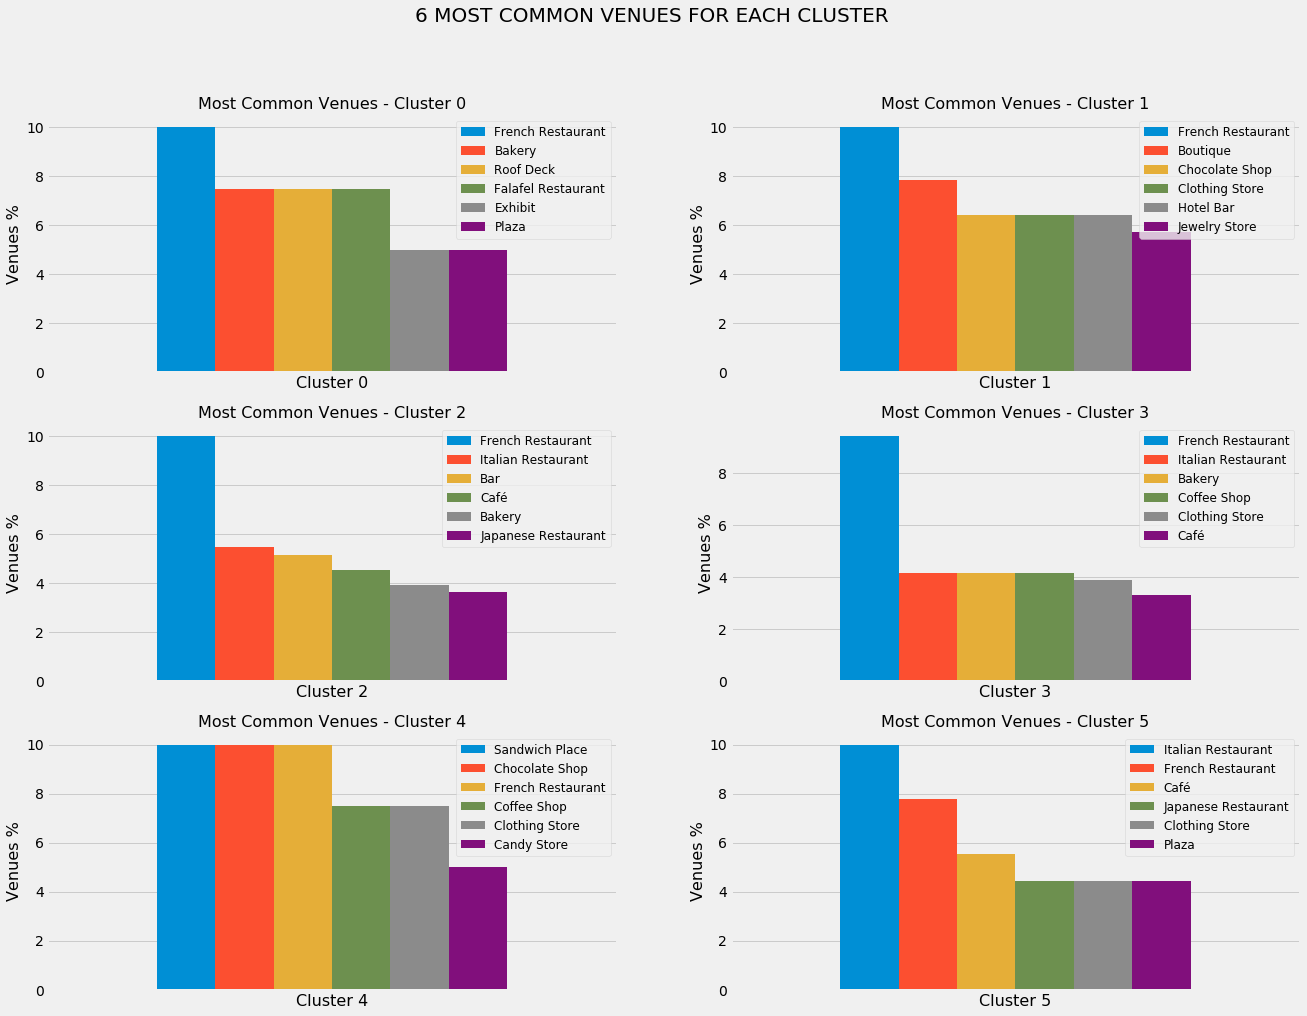

In [56]:
cluster_common_venues(data = nearby_venues_merged, clusters = list(range(6)), figsize=(20,15), n_venues=6)

It was observed that the category 'French Restaurant' appears among the most common in all clusters, being the 1st or 2nd most common venue. This information is interesting and somewhat unexpected, as there is a specific category for French restaurants in a French city, which was not observed similarly in Toronto, as no place classified as Canadian Restaurant was noticed.

As there is such a specific classification for French restaurants, and such a category is suggestively among the most common venues within the city of Paris in France, it may be interesting to remove them from the information used to carry out the grouping, as they may not represent useful information, since it is Expected to have French restaurants around most hotels in France.

# Hotels Rating

Due to the daily limit of 50 premium requests that we can make on Foursquare, it was necessary to collect the evaluations of all 100 hotels used in this project in 3 parts, this task was carried out in a period of 3 days. The result can be seen on the dataframe below.

In [57]:
hotels_ratings = pd.read_csv('ratings/hotels_ratings.csv')
hotels_ratings.head()

,Hotel,Hotel Id,Ratings
0,Hôtel Le Meurice,4b8b0cbef964a5203b9032e3,8.7
1,Hôtel Bel Ami,4b6ae8dbf964a52066e62be3,8.7
2,InterContinental Paris Le Grand Hôtel,4adcda03f964a520d13121e3,8.6
3,Grand Hôtel du Palais Royal,4b50f4d4f964a5207e3a27e3,8.3
4,Hôtel Les Jardins du Marais,4b7051cdf964a5205b122de3,8.1


# Merge Hotel Rating

Adding ratings to the dataset nearby_venues_merged

In [58]:
paris_nearby_venues_merged = nearby_venues_merged.join(hotels_ratings[['Hotel', 'Ratings']].set_index('Hotel'), on='Hotel')
paris_nearby_venues_merged.head()

,Hotel,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Ratings
0,Hôtel Le Meurice,48.865333,2.328137,1,French Restaurant,Café,Hotel Bar,Chocolate Shop,Japanese Restaurant,Pastry Shop,Beer Garden,Clothing Store,Bookstore,Dessert Shop,8.7
1,Hôtel Bel Ami,48.854918,2.333141,5,Italian Restaurant,French Restaurant,Plaza,Café,Japanese Restaurant,Cosmetics Shop,Clothing Store,Boutique,Sandwich Place,Steakhouse,8.7
2,InterContinental Paris Le Grand Hôtel,48.870836,2.330725,4,Chocolate Shop,Coffee Shop,Clothing Store,Men's Store,Electronics Store,Sandwich Place,Candy Store,French Restaurant,Furniture / Home Store,Roof Deck,8.6
3,Grand Hôtel du Palais Royal,48.863183,2.337901,2,French Restaurant,Plaza,Café,Historic Site,Coffee Shop,Theater,Shoe Store,Spa,Sculpture Garden,Garden,8.3
4,Hôtel Les Jardins du Marais,48.860699,2.368530,3,Bar,Café,French Restaurant,Restaurant,Art Gallery,Clothing Store,Pizza Place,Coffee Shop,Tea Room,Bistro,8.1


Reordering DataFrame columns

In [59]:
# get columns name as list
cols = paris_nearby_venues_merged.columns.tolist()

# get Hotel column index and pop (remove) from list
index_hotel = cols.index('Hotel')
cols.pop(index_hotel)

# get Ratings column index and pop (remove) from list
index_ratings = cols.index('Ratings')
cols.pop(index_ratings)

# create list starting with [Hotel, Ratings] + [cols]
cols = ['Hotel', 'Ratings'] + cols

# set new column order
paris_nearby_venues_merged = paris_nearby_venues_merged[cols]

# heading dataframe
paris_nearby_venues_merged.head(5)

,Hotel,Ratings,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hôtel Le Meurice,8.7,48.865333,2.328137,1,French Restaurant,Café,Hotel Bar,Chocolate Shop,Japanese Restaurant,Pastry Shop,Beer Garden,Clothing Store,Bookstore,Dessert Shop
1,Hôtel Bel Ami,8.7,48.854918,2.333141,5,Italian Restaurant,French Restaurant,Plaza,Café,Japanese Restaurant,Cosmetics Shop,Clothing Store,Boutique,Sandwich Place,Steakhouse
2,InterContinental Paris Le Grand Hôtel,8.6,48.870836,2.330725,4,Chocolate Shop,Coffee Shop,Clothing Store,Men's Store,Electronics Store,Sandwich Place,Candy Store,French Restaurant,Furniture / Home Store,Roof Deck
3,Grand Hôtel du Palais Royal,8.3,48.863183,2.337901,2,French Restaurant,Plaza,Café,Historic Site,Coffee Shop,Theater,Shoe Store,Spa,Sculpture Garden,Garden
4,Hôtel Les Jardins du Marais,8.1,48.860699,2.368530,3,Bar,Café,French Restaurant,Restaurant,Art Gallery,Clothing Store,Pizza Place,Coffee Shop,Tea Room,Bistro


# Application

So, let's say that a customer has already visited Toronto, and was extremely satisfied with his place of accommodation by assigning a rating of 9.7, we can now use the data from his old trip to suggest a hotel in the city of Paris that has nearby locations similar to that of Toronto. 

### Retrieving information from Toronto

First, we need to retrieve the information from the Hotel where the client was staying in Toronto.

In [60]:
costumer_venue = pd.read_csv('costumer/costumer_venue.csv')
costumer_venue

,City,City Latitude,City Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
0,Toronto,43.653482,-79.383935,Marriott Downtown at CF Toronto Eaton Centre,4b0563c0f964a5200e5822e3,43.654728,-79.382422,Hotel


In [61]:
costumer_venue_grouped = pd.read_csv('costumer/costumer_venue_grouped.csv')
costumer_venue_grouped

,Hotel,Wine Bar,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Bookstore,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Distribution Center,Electronics Store,Ethiopian Restaurant,Fast Food Restaurant,Food Court,Furniture / Home Store,Garden,Gastropub,General Travel,Gift Shop,Gluten-free Restaurant,Greek Restaurant,Gym,Gym / Fitness Center,Hobby Shop,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Noodle House,Office,Opera House,Park,Pharmacy,Pie Shop,Pizza Place,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant
0,Marriott Downtown at CF Toronto Eaton Centre,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.026316,0.0,0.0,0.026316,0.0,0.026316,0.0,0.0,0.0,0.131579,0.026316,0.052632,0.0,0.026316,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.026316,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.026316,0.026316,0.0,0.0,0.0,0.026316,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.052632,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,0.026316,0.026316,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.026316,0.0,0.0,0.026316,0.0,0.026316,0.026316


In [62]:
costumer_venues_merged = pd.read_csv('costumer/costumer_venues_merged.csv')
costumer_venues_merged

,Hotel,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marriott Downtown at CF Toronto Eaton Centre,43.654728,-79.382422,0,Clothing Store,Plaza,Diner,Coffee Shop,Cosmetics Shop,Vietnamese Restaurant,Neighborhood,Restaurant,Pizza Place,Comic Shop


### Preparing Toronto Data

First we need to remove the Hotel column, as it is a feature that is not part of the grouping.

In [63]:
costumer_venue_grouped = costumer_venue_grouped.drop('Hotel', 1)
costumer_venue_grouped

,Wine Bar,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Bookstore,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Distribution Center,Electronics Store,Ethiopian Restaurant,Fast Food Restaurant,Food Court,Furniture / Home Store,Garden,Gastropub,General Travel,Gift Shop,Gluten-free Restaurant,Greek Restaurant,Gym,Gym / Fitness Center,Hobby Shop,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Music Venue,Neighborhood,New American Restaurant,Noodle House,Office,Opera House,Park,Pharmacy,Pie Shop,Pizza Place,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant
0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.026316,0.0,0.0,0.026316,0.0,0.026316,0.0,0.0,0.0,0.131579,0.026316,0.052632,0.0,0.026316,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.026316,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.026316,0.026316,0.0,0.0,0.0,0.026316,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.052632,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,0.026316,0.026316,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.026316,0.0,0.0,0.026316,0.0,0.026316,0.026316


Although we look for similarity between the place of accommodation in Toronto and the clusters of Paris, we must also know that they have differences, one of them is that in the Toronto hotel dataset there is not the same variety of places observed in Paris. Thus, it is necessary to transform the Toronto dataset so that it has the same columns as expected in the Paris dataset, so that the classification of Toronto to a Paris cluster can be performed.

Such a transformation is done by removing the columns from Toronto that are not present in Paris, and adding with 0 values the columns that are present in Paris, but are not part of Toronto.

In [64]:
merge_df_cols = costumer_venue_grouped.columns.tolist()
df_cols = get_venues_grouped_clustering.columns.tolist()

# get columns name diffence between dataframes
difference = set(df_cols) - set(merge_df_cols)

# remove the different columns between two lists
for venue in difference:
    try:
        merge_df_cols.remove(venue)
    except:
        pass

# get the new differences
difference = set(df_cols) - set(merge_df_cols)

# completing different columns with np_zero values
for column in difference:
    costumer_venue_grouped[column] = np.float64(0)
    
# set new column order
merge_df = costumer_venue_grouped[df_cols]
merge_df

,Accessories Store,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Candy Store,Cantonese Restaurant,Caucasian Restaurant,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Internet Cafe,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Laser Tag,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Predict Toronto Hotel Cluster

Now, we can find which cluster is more similar to the Toronto hotel.

In [65]:
cluster = kmeans.predict(merge_df)[0].item()
print("The hotels in Paris to be indicated to the customer belong to the cluster {}".format(cluster))

The hotels in Paris to be indicated to the customer belong to the cluster 3


### Suggesting Paris Hotels

With the classification carried out, we can suggest the top 5 Hotels by rating for the cluster found.

In [66]:
suggestion = paris_nearby_venues_merged.loc[paris_nearby_venues_merged['Cluster Labels'] == cluster, 
                         paris_nearby_venues_merged.columns[[0,1] + list(range(4, paris_nearby_venues_merged.shape[1]))]].sort_values('Ratings', ascending=False).head(5)
suggestion

,Hotel,Ratings,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,The Hoxton Paris,9.1,3,Bar,Cocktail Bar,Wine Bar,French Restaurant,Italian Restaurant,Chinese Restaurant,Theater,Salad Place,Gym / Fitness Center,Indian Restaurant
11,Hôtel Barrière Le Fouquet's,8.9,3,French Restaurant,Asian Restaurant,Café,Pastry Shop,Cosmetics Shop,Clothing Store,Electronics Store,Bakery,Hotel Bar,Halal Restaurant
22,Hotel Atmospheres,8.8,3,French Restaurant,Italian Restaurant,Bakery,Coffee Shop,Tapas Restaurant,Portuguese Restaurant,Seafood Restaurant,Ethiopian Restaurant,Flower Shop,Market
23,Hôtel Jules & Jim,8.8,3,French Restaurant,Chinese Restaurant,Café,Art Gallery,Wine Bar,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Restaurant,Museum
20,Hôtel Caron de Beaumarchais,8.7,3,French Restaurant,Clothing Store,Falafel Restaurant,Pastry Shop,Wine Bar,Plaza,Italian Restaurant,Ice Cream Shop,Bistro,Furniture / Home Store


### Most Common Venues for Suggested Cluster.

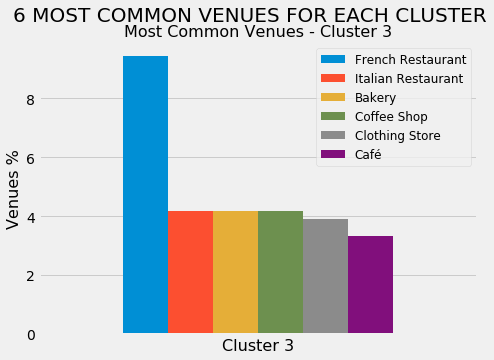

In [67]:
cluster_common_venues(data = nearby_venues_merged, clusters = [cluster], figsize=(7,5), n_venues=6)

### Visualize Recommended Hotels Map

Getting DataFrame with lat-long coordinates to the recommended hotels

In [68]:
suggestion_map = hotel_venues.loc[hotel_venues['Hotel'].isin(suggestion['Hotel'].to_list())]
suggestion_map

,Hotel,Hotel Latitude,Hotel Longitude
11,Hôtel Barrière Le Fouquet's,48.871079,2.301236
20,Hôtel Caron de Beaumarchais,48.856448,2.356729
22,Hotel Atmospheres,48.848695,2.348145
23,Hôtel Jules & Jim,48.863496,2.357395
27,The Hoxton Paris,48.870179,2.346632


Making a map with recommended hotels

In [69]:
# create map of hotels using latitude and longitude values
map_hotels = folium.Map(location=[latitude, longitude], zoom_start=12.5)

code_color = '#2776DB'
# add markers to map
for lat, lng, venue in zip(suggestion_map['Hotel Latitude'], suggestion_map['Hotel Longitude'], 
                                           suggestion_map['Hotel']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color=code_color,
        fill=True,
        fill_color=code_color,
        fill_opacity=1,
        parse_html=False).add_to(map_hotels)  
    
map_hotels

As the map created above is interactive, it may not be visible on github. So we will import and show below the result of the preview obtained on 16/01/21.

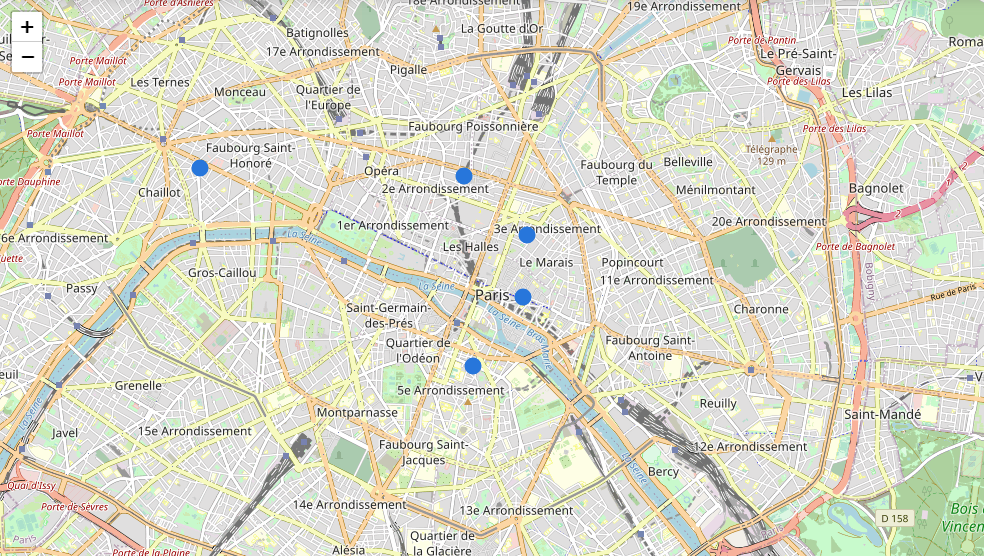

In [70]:
Image(filename='folium_maps/folium_suggested_hotels_map.png') 

# Conclusion

With the data obtained via requests to the Foursquare API we were able to collect and group several hotels in the city of Paris, and then with historical data about a given customer, we were able to suggest the best hotels for accommodation based on such data.

Despite the satisfactory result for a first version of this project, there are a lot of things that can be improved in future works, such as using more than one data source, gaining access to a higher number of requests to the Foursquare API, use other metrics to evaluate our model and choose the best number of clusters, perform the segmentation for a set that contains more than one city, in short, there are many possibilities, so now it remains to continue the studies and to improve the projects developed with the knowledge acquired over time.

Thank for your time reading this project :)

# Acknowledgements

My thanks to the Coursera course platform, to IBM and all instructors in the Data Science - Professional Certificate courses, for providing such a courses and materials that enabled the development of this project.

# References

IBM Data Science Professional Certificate | https://www.coursera.org/professional-certificates/ibm-data-science

One Hot Encode | https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

An Introduction to Clustering and different methods of clustering | https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering/#:~:text=Clustering%20is%20the%20task%20of,and%20assign%20them%20into%20clusters.

K-Means - Scikit-learn | https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Entenda o algoritmo k-means | https://minerandodados.com.br/entenda-o-algoritmo-k-means/

Selecting the number of clusters with silhouette analysis on KMeans clustering | https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Forusquare - Documentation for Developers| https://developer.foursquare.com/docs/

Pandas - User Guide | https://pandas.pydata.org/docs/user_guide/index.html

Folium - Documentation | https://python-visualization.github.io/folium/

A lot of things in StackOverflow :) | https://stackoverflow.com/

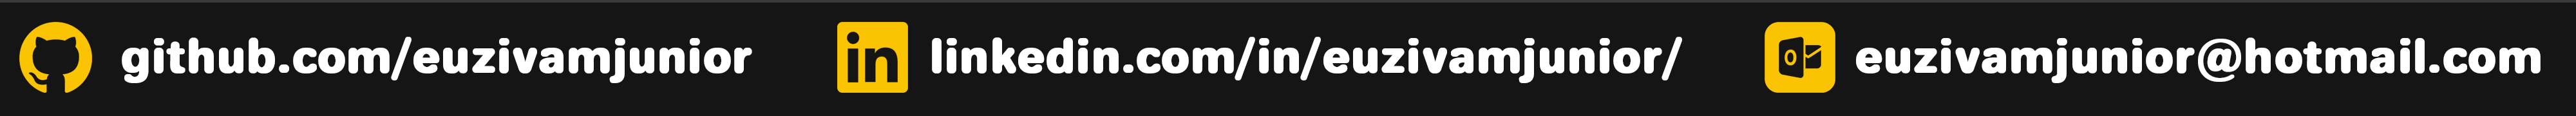